In [12]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

REPORT_FILE_PATH = Path('../llm-answer-results/reports')
FIGURE_FILE_PATH = Path('../llm-answer-results/figures/')

from base_evaluator import HUMAN_EVALUATED_ANSWERS_REFERENCE_PATH

sns.set_theme()

In [17]:
validate_file_names = [
    path.name for path in ('../../' / HUMAN_EVALUATED_ANSWERS_REFERENCE_PATH).iterdir()]

len(validate_file_names)

20

In [7]:
gpt_custom_df = pd.read_csv(REPORT_FILE_PATH / '2024-03-25' / 'gpt-custom_llm_auto_score.csv')
gpt_df = pd.read_csv(REPORT_FILE_PATH / '2023-11-25' / 'gpt_llm_auto_score.csv')

In [20]:
gpt_custom_df = gpt_custom_df[gpt_custom_df['file_name'].isin(validate_file_names)]
gpt_df = gpt_df[gpt_df['file_name'].isin(validate_file_names)]

In [34]:
gpt_custom_df.head()

,file_name,question,human_answer,llm_answer,score,llm_type
0,807.txt,\nCo je to exponenciální časová složitost?\n,\nBohužel není možné odpovědět na základě posk...,\nExponenciální časová složitost je složitost ...,1,gpt-custom
1,125.txt,\nO co se v této věci vedl spor? (jednou větou)\n,\nŽalobkyně požadavala zaplacení částky za odb...,\nŽalobkyně požaduje zaplacení předmětné částk...,10,gpt-custom
2,949.txt,\nČeho se týkala smlouva mezi žalobkyní a žalo...,\nSmlouva se týkala dodávky zemního plynu do o...,\nSmlouva o dodávce zemního plynu.,5,gpt-custom
3,1898.txt,\nJakými dopravními prostředky cestovala žalov...,\nŽalovaná cestovala autobusem MHD a trolejbus...,\nŽalovaná cestovala trolejbusem MHD.,5,gpt-custom
4,1927.txt,\nKolik ústních jednání ve věci proběhlo?\n,"\nVe věci žádné ústní jednání neproběhlo, účas...",\nJedno.,1,gpt-custom


In [86]:
gpt_custom_df['llm_type'] = 'GPT po finetuningu'
gpt_df['llm_type'] = 'GPT před finetuningem'

merged_df = pd.concat([gpt_custom_df, gpt_df])
merged_df.reset_index(inplace=True, drop=True)

/tmp/ipykernel_89057/1048605620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpt_custom_df['llm_type'] = 'GPT po finetuningu'


In [87]:
merged_df.groupby('llm_type')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
llm_type,,,,,,,,
GPT po finetuningu,20.0,6.75,3.258592,1.0,4.75,6.5,10.0,10.0
GPT před finetuningem,20.0,6.40,3.704904,1.0,3.50,7.5,10.0,10.0


In [99]:
result_table = merged_df.groupby('llm_type')['score'].describe()
result_table['std'] = result_table['std'].round(2)
result_table['mean'] = result_table['mean'].round(2)
result_table['50%'] = result_table['50%'].round(2)
result_table.rename(columns={'count': 'počet', 'mean': 'průměr', 'std': 'směrodatná odchylka', '50%': 'medián'}, inplace=True)
result_table.index.names = ['Typ LLM']
result_table[['počet', 'průměr', 'směrodatná odchylka', 'medián']].to_csv(FIGURE_FILE_PATH/'finetuning_score_by_type.csv')

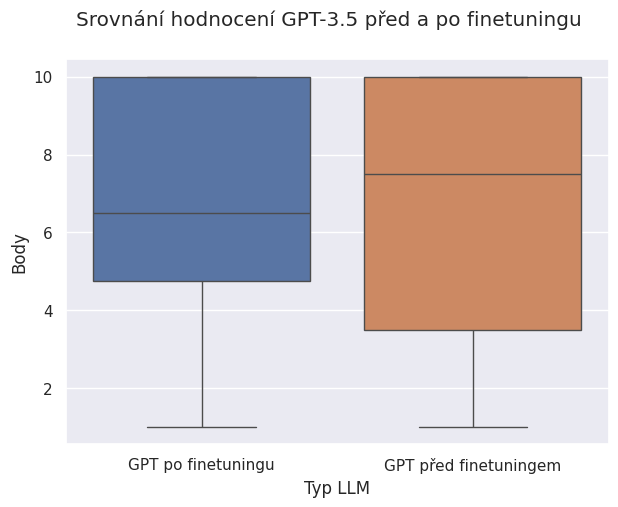

In [88]:
f, ax = plt.subplots(figsize=(7, 5))

f.suptitle('Srovnání hodnocení GPT-3.5 před a po finetuningu')
g =sns.boxplot(merged_df, ax=ax, y='score', x='llm_type', hue='llm_type')
ax.set(ylabel='Body', xlabel='Typ LLM')

f.savefig(FIGURE_FILE_PATH / 'finetuning_boxplot.png')

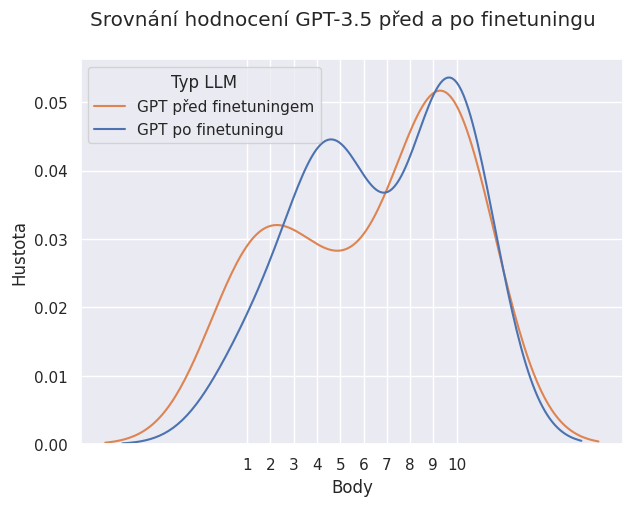

In [93]:
f, ax = plt.subplots(figsize=(7, 5))
# sns.despine(f)

ax.set_xticks(range(1,11))
f.suptitle('Srovnání hodnocení GPT-3.5 před a po finetuningu')
g =sns.kdeplot(merged_df, ax=ax, x='score', hue='llm_type')

ax.set(xlabel='Body', ylabel='Hustota')
ax.legend(title='Typ LLM', labels=['GPT před finetuningem', 'GPT po finetuningu'])

f.savefig(FIGURE_FILE_PATH / 'finetuning_kde.png')

In [97]:
from scipy import stats

stats.wilcoxon(merged_df[merged_df['llm_type'] == 'GPT před finetuningem']
               ['score'], merged_df[merged_df['llm_type'] == 'GPT po finetuningu']['score'])

WilcoxonResult(statistic=60.5, pvalue=0.6970431275403315)

In [116]:
training_metrics_df = pd.read_csv(REPORT_FILE_PATH / '2024-03-25' / 'step_metrics.csv')
training_metrics_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,1.91695,0.77778,1.33291,0.72000
1,2,0.58020,0.89189,2.18490,0.54286
2,3,1.40749,0.80000,1.50783,0.65625
3,4,2.03816,0.78947,0.57892,0.76923
4,5,0.09267,0.98621,0.93608,0.66667


In [156]:
merged_training_metrics_df = training_metrics_df.drop(columns=['valid_mean_token_accuracy', 'train_accuracy']).melt(id_vars=['step'], value_vars=['train_loss', 'valid_loss'], var_name='loss_type')

merged_training_metrics_df['loss_type'].replace({'train_loss': 'Trénovací', 'valid_loss': 'Validační'}, inplace=True)

merged_training_metrics_df.head()

/tmp/ipykernel_89057/1947754394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_training_metrics_df['loss_type'].replace({'train_loss': 'Trénovací', 'valid_loss': 'Validační'}, inplace=True)


,step,loss_type,value
0,1,Trénovací,1.91695
1,2,Trénovací,0.58020
2,3,Trénovací,1.40749
3,4,Trénovací,2.03816
4,5,Trénovací,0.09267


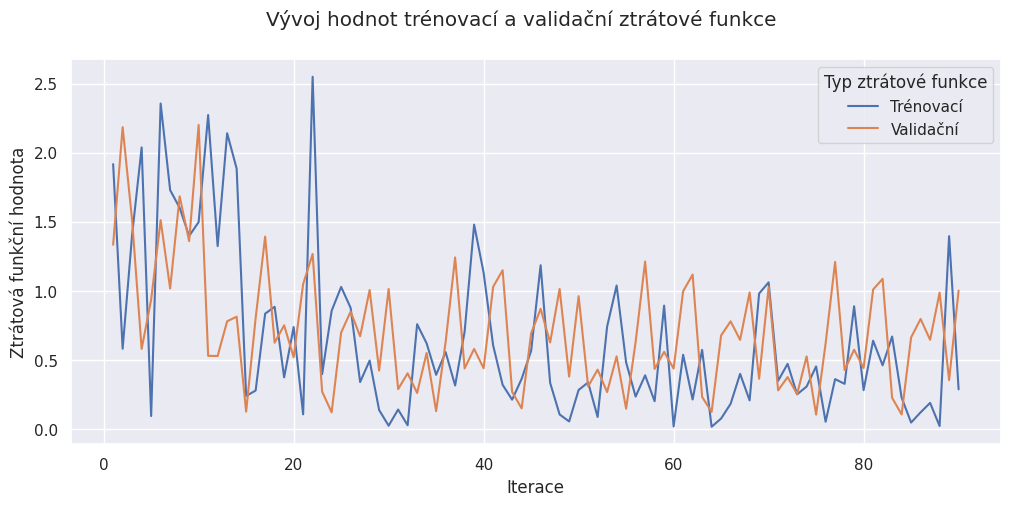

In [157]:
f, ax = plt.subplots(figsize=(12, 5))

f.suptitle('Vývoj hodnot trénovací a validační ztrátové funkce')
g =sns.lineplot(merged_training_metrics_df, ax=ax, y='value', x='step', hue='loss_type')
ax.legend(title='Typ ztrátové funkce')

ax.set(xlabel='Iterace', ylabel='Ztrátová funkční hodnota')

f.savefig(FIGURE_FILE_PATH / 'finetuning_metrics.png')